In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

新建一个full数据集方便训练集和测试集的数据处理。
训练的时候id是没用的，所以先把测试集的id那一列先提取出来，再删掉。

In [2]:
train = pd.read_csv('~/data/task3_2/sf-crime/train.csv')
test = pd.read_csv('~/data/task3_2/sf-crime/test.csv')
full = train.append(test, ignore_index=True)
test_id = full[train.shape[0]:]['Id'].astype(int)
full = full.drop(['Id'], axis=1)

In [3]:
locations = set()
def getLocation(x):
    if 'Block' in x:
        locations.add(x.split('of')[-1].strip())
        return [x.split('of')[-1].strip()]
    else:
        locations.add(x.split('/')[0].strip())
        locations.add(x.split('/')[1].strip())
        return [x.split('/')[0].strip(), x.split('/')[1].strip()]
full['Locations'] = full['Address'].apply(getLocation)


In [4]:
full['Locations']

0                 [OAK ST, LAGUNA ST]
1                 [OAK ST, LAGUNA ST]
2          [VANNESS AV, GREENWICH ST]
3                        [LOMBARD ST]
4                      [BRODERICK ST]
                      ...            
1762306                   [BRYANT ST]
1762307               [WASHINGTON ST]
1762308                  [MISSION ST]
1762309                   [HUDSON AV]
1762310                    [SLOAT BL]
Name: Locations, Length: 1762311, dtype: object

In [5]:
locations = list(locations)
for location in locations:
    if len(location.split(' ')[-1]) != 2:
        locations.remove(location)

In [6]:
suffixes = set()
for location in locations:
    suffixes.add(location.split(' ')[-1])
suffixes = list(suffixes)
suffixes

['PL',
 'WK',
 'WY',
 'AV',
 'DR',
 'HY',
 'PZ',
 'TR',
 'RD',
 'ST',
 'LN',
 'RW',
 'CR',
 'BL',
 'AL',
 'CT',
 'EX']

In [7]:
# suffixes.append('OTHERS')
def countSuffix(li, suffix):
    cnt = 0
    for x in li:
        if x.split(' ')[-1] == suffix:
            cnt += 1
    return cnt

for suffix in suffixes:
    full['suffix-' + suffix] = full['Locations'].map(lambda x: countSuffix(x, suffix))

In [8]:
def countOthers(li):
    cnt = 0
    for x in li:
        if x.split(' ')[-1] not in suffixes:
            cnt += 1
    return cnt

full['suffix-OTHERS'] = full['Locations'].map(countOthers)

In [9]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762311 entries, 0 to 1762310
Data columns (total 28 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Dates          object 
 1   Category       object 
 2   Descript       object 
 3   DayOfWeek      object 
 4   PdDistrict     object 
 5   Resolution     object 
 6   Address        object 
 7   X              float64
 8   Y              float64
 9   Locations      object 
 10  suffix-PL      int64  
 11  suffix-WK      int64  
 12  suffix-WY      int64  
 13  suffix-AV      int64  
 14  suffix-DR      int64  
 15  suffix-HY      int64  
 16  suffix-PZ      int64  
 17  suffix-TR      int64  
 18  suffix-RD      int64  
 19  suffix-ST      int64  
 20  suffix-LN      int64  
 21  suffix-RW      int64  
 22  suffix-CR      int64  
 23  suffix-BL      int64  
 24  suffix-AL      int64  
 25  suffix-CT      int64  
 26  suffix-EX      int64  
 27  suffix-OTHERS  int64  
dtypes: float64(2), int64(18), object(8)
memory

接下来我们一边看数据特征，一边给数据做处理。

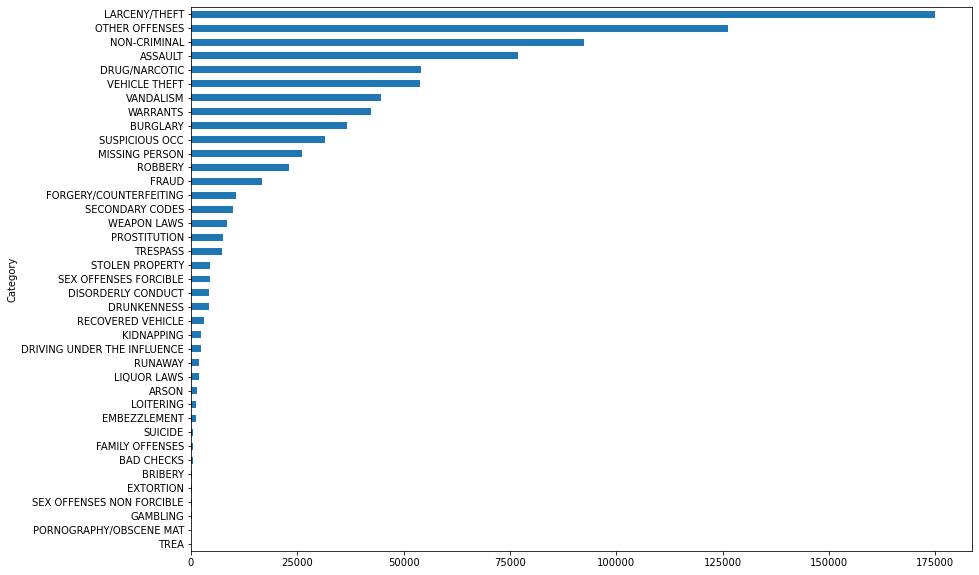

In [10]:
plt.figure(figsize=(14, 10))
train.groupby([train['Category']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# number of each category

好家伙，可以看出绝大部分都是入室盗窃，其他罪行、无罪、袭击也占据一定比例。

In [11]:
full.isnull().sum()

Dates                 0
Category         884262
Descript         884262
DayOfWeek             0
PdDistrict            0
Resolution       884262
Address               0
X                     0
Y                     0
Locations             0
suffix-PL             0
suffix-WK             0
suffix-WY             0
suffix-AV             0
suffix-DR             0
suffix-HY             0
suffix-PZ             0
suffix-TR             0
suffix-RD             0
suffix-ST             0
suffix-LN             0
suffix-RW             0
suffix-CR             0
suffix-BL             0
suffix-AL             0
suffix-CT             0
suffix-EX             0
suffix-OTHERS         0
dtype: int64

这里的Category就是我们需要做多分类预测的结果。Descript跟Resolution相对影响不大，是对Category的补充说明而已。
这三个特征是用来监督训练结果的，通过Category的种类进行多分类。

所以对Dates、DayOfWeek、PdDistrict、Address、X、Y这几个特征，我们开始做特征的处理。


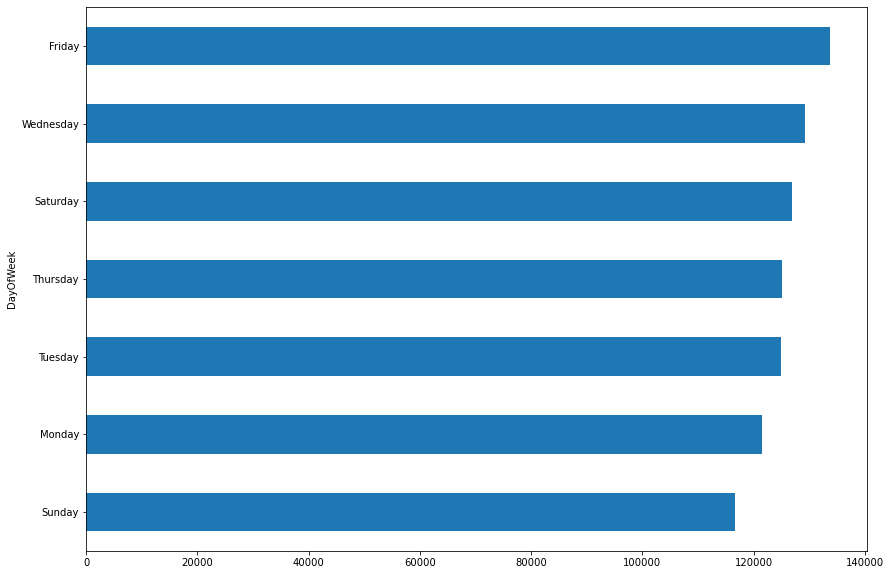

In [12]:
plt.figure(figsize=(14, 10))
train.groupby([train['DayOfWeek']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about day-of-the-week

可以发现，犯罪的案件数跟是星期中的哪一天关系可以说不是很大，在星期中的每一天都比较均衡。

不过在星期五最多，在星期天最少。这个信息也许可以拆成工作日跟非工作日的一个新特征。

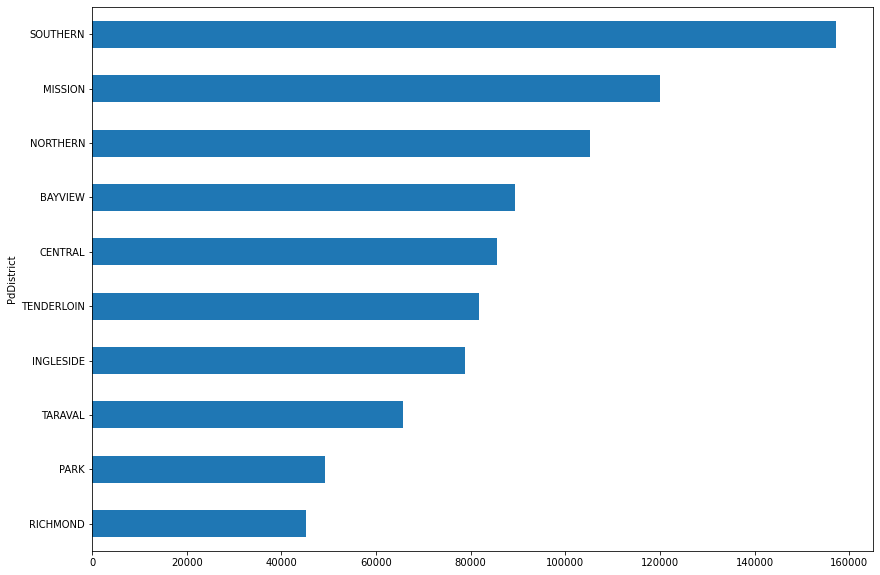

In [13]:
plt.figure(figsize=(14, 10))
train.groupby([train['PdDistrict']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about PdDistict

SF南部警区出现的犯罪案件数明显多余其他地方，北方跟Mission的警署也挺多的。

In [14]:

train['Year'] = train['Dates'].map(lambda x: int(x.split('-')[0].strip()))
full['Year'] = full['Dates'].map(lambda x: int(x.split('-')[0].strip()))

train['Month'] = train['Dates'].map(lambda x: int(x.split('-')[1].strip()))
full['Month'] = full['Dates'].map(lambda x: int(x.split('-')[1].strip()))

train['Day'] = train['Dates'].map(lambda x: int(x.split('-')[1].strip()))
full['Day'] = full['Dates'].map(lambda x: int(x.split('-')[1].strip()))


In [15]:
def getSeason(n):
    if 3 <= n <= 5:
        return 1
    elif 6 <= n <= 8:
        return 2
    elif 9 <= n <= 11:
        return 3
    elif n == 12 or 1 <= n <= 2:
        return 4
    else:
        return 0

train['Season'] = train['Month'].map(getSeason)
full['Season'] = full['Month'].map(getSeason)

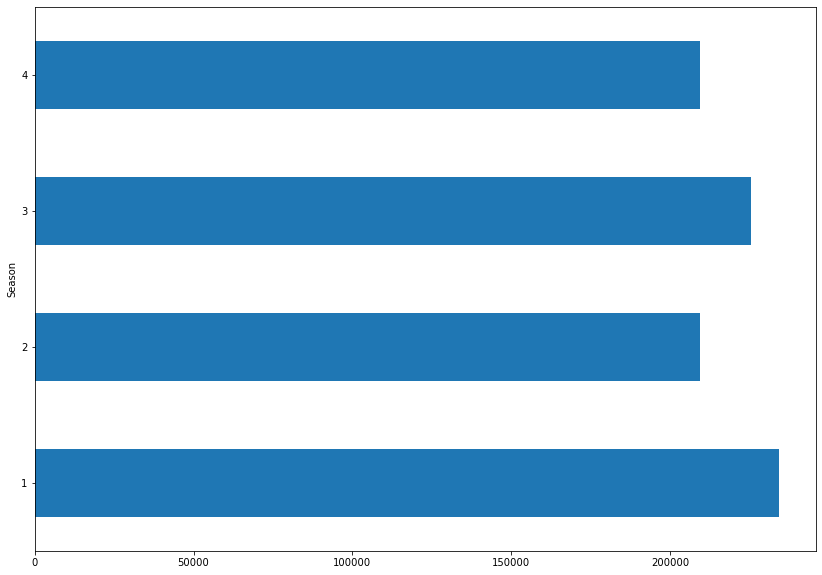

In [16]:
plt.figure(figsize=(14, 10))
train.groupby('Season').size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about season

In [17]:
def getIsWeekday(day):
    if day == 'Saturday' or day == 'Sunday':
        return 0
    else:
        return 1

train['IsWeekday'] = train['DayOfWeek'].map(getIsWeekday)
full['IsWeekday'] = full['DayOfWeek'].map(getIsWeekday)

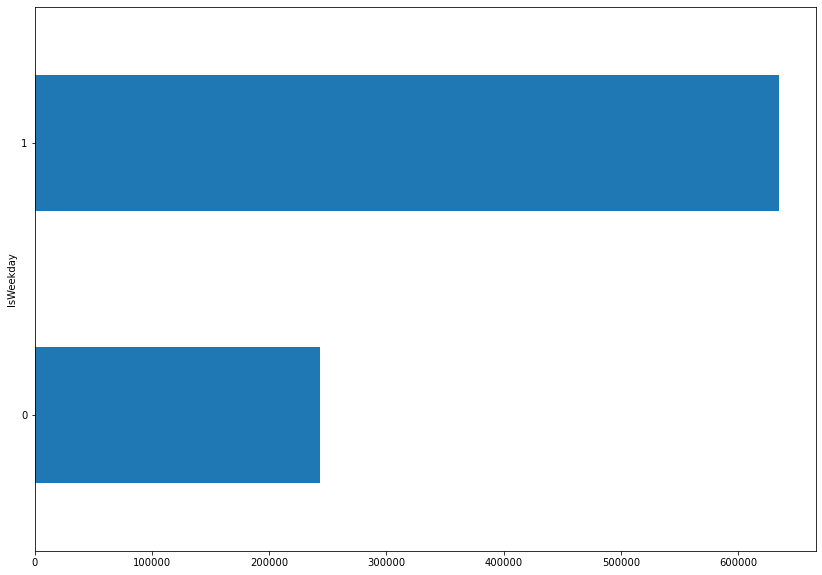

In [18]:
plt.figure(figsize=(14, 10))
train.groupby('IsWeekday').size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about whether it is weekday

In [19]:
def getHourZone(hour):
    if 0 <= hour <= 8:
        return 1
    elif 9 <= hour <= 11:
        return 2
    elif 12 <= hour <= 13:
        return 3
    elif 14 <= hour <= 16:
        return 4
    elif 17 <= hour <= 19:
        return 5
    elif 20 <= hour <= 23:
        return 6
    else:
        return 0
train['Hour'] = train['Dates'].map(lambda x: int(x.split(' ')[1].split(':')[0].strip()))
full['Hour'] = full['Dates'].map(lambda x: int(x.split(' ')[1].split(':')[0].strip()))

train['HourZone'] = train['Hour'].map(getHourZone)
full['HourZone'] = full['Hour'].map(getHourZone)

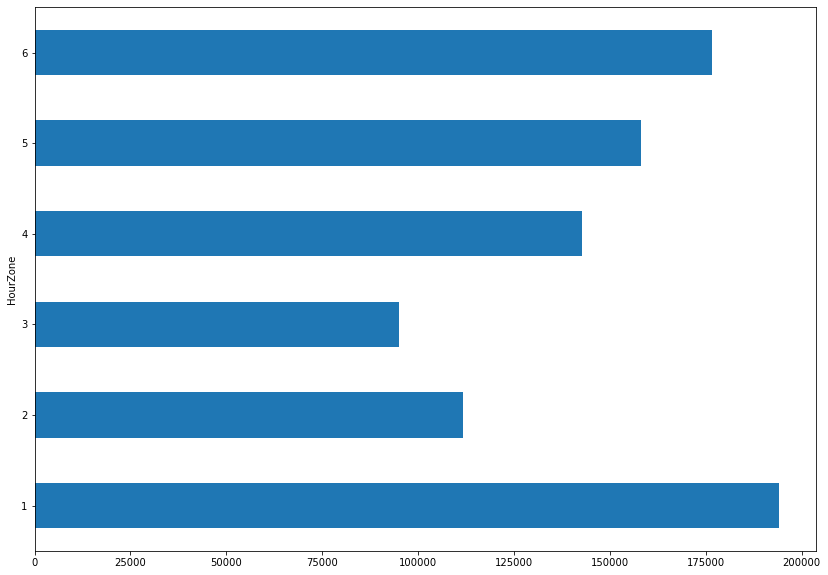

In [20]:
plt.figure(figsize=(14, 10))
train.groupby('HourZone').size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about whether it is weekday

好家伙，这个数据结果非常符合先验知识，在夜晚的犯罪案件要显著多于白天，并且半夜是最多的。

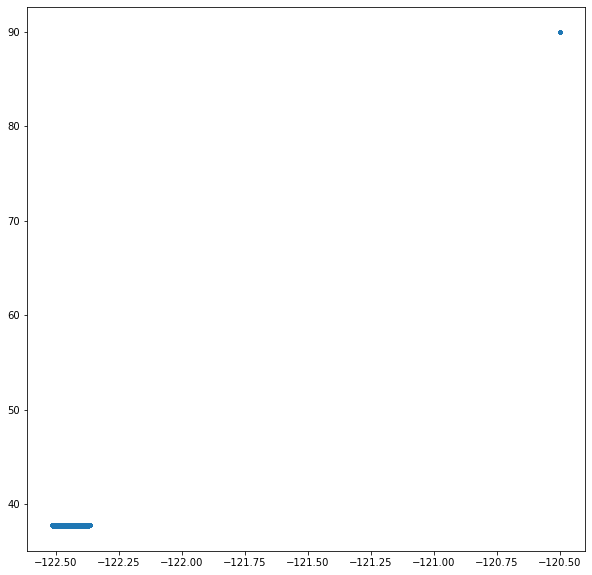

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(train['X'], train['Y'], marker='.')
plt.show()

维度到了北纬90度就离谱。所以我们需要处理异常值，把大于北纬40度的数据全删了。

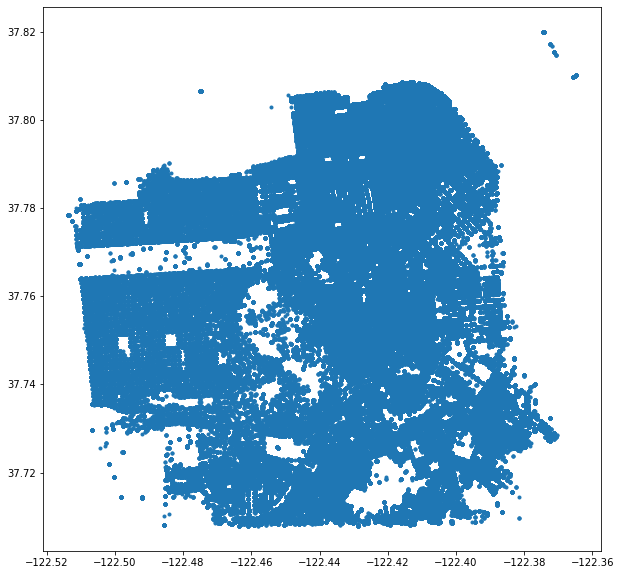

In [22]:
temp = train[train['Y'] < 40]
plt.figure(figsize=(10, 10))
plt.scatter(temp['X'], temp['Y'], marker='.')
plt.show()
# don't change test here

更奇妙的是，居然在测试集里还出现了76个北纬90度的东西。
肯定是坐标未知，这种情况我们弄个众数、中位数或者平均数去填补缺失数据。

In [23]:
import re
def getAddressType(addr):
    if 'Block' in addr:
        return 1
    else:
        return 0

def getAddressNum(addr):
    temp = re.findall(r"\d+", addr)
    if len(temp) == 0:
        return -1
    else:
        return int(temp[0])

train['AddressType'] = train['Address'].map(getAddressType)
train['AddressNum'] = train['Address'].map(getAddressNum)
full['AddressType'] = full['Address'].map(getAddressType)
full['AddressNum'] = full['Address'].map(getAddressNum)

In [24]:
dayofweek_dict = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
full['DayOfWeek'] = full['DayOfWeek'].map(lambda x: dayofweek_dict[x])


In [25]:
full = full.drop(['Descript', 'Resolution', 'Address', 'Dates'], axis=1)
train = train.drop(['Descript', 'Resolution', 'Address', 'Dates'], axis=1)

In [26]:
full

,Category,DayOfWeek,PdDistrict,X,Y,Locations,suffix-PL,suffix-WK,suffix-WY,suffix-AV,...,suffix-OTHERS,Year,Month,Day,Season,IsWeekday,Hour,HourZone,AddressType,AddressNum
0,WARRANTS,3,NORTHERN,-122.425892,37.774599,"[OAK ST, LAGUNA ST]",0,0,0,0,...,0,2015,5,5,1,1,23,6,0,-1
1,OTHER OFFENSES,3,NORTHERN,-122.425892,37.774599,"[OAK ST, LAGUNA ST]",0,0,0,0,...,0,2015,5,5,1,1,23,6,0,-1
2,OTHER OFFENSES,3,NORTHERN,-122.424363,37.800414,"[VANNESS AV, GREENWICH ST]",0,0,0,1,...,0,2015,5,5,1,1,23,6,0,-1
3,LARCENY/THEFT,3,NORTHERN,-122.426995,37.800873,[LOMBARD ST],0,0,0,0,...,0,2015,5,5,1,1,23,6,1,1500
4,LARCENY/THEFT,3,PARK,-122.438738,37.771541,[BRODERICK ST],0,0,0,0,...,0,2015,5,5,1,1,23,6,1,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762306,NaN,3,MISSION,-122.408983,37.751987,[BRYANT ST],0,0,0,0,...,0,2003,1,1,4,1,0,1,1,2600
1762307,NaN,3,NORTHERN,-122.425342,37.792681,[WASHINGTON ST],0,0,0,0,...,0,2003,1,1,4,1,0,1,1,1900
1762308,NaN,3,INGLESIDE,-122.445418,37.712075,[MISSION ST],0,0,0,0,...,0,2003,1,1,4,1,0,1,1,5500
1762309,NaN,3,BAYVIEW,-122.387394,37.739479,[HUDSON AV],0,0,0,1,...,0,2003,1,1,4,1,0,1,1,1500


In [27]:
from sklearn.preprocessing import LabelEncoder
full['PdDistrict'] = LabelEncoder().fit_transform(full['PdDistrict'])
full['AddressNum'] = LabelEncoder().fit_transform(full['AddressNum'])
full

,Category,DayOfWeek,PdDistrict,X,Y,Locations,suffix-PL,suffix-WK,suffix-WY,suffix-AV,...,suffix-OTHERS,Year,Month,Day,Season,IsWeekday,Hour,HourZone,AddressType,AddressNum
0,WARRANTS,3,4,-122.425892,37.774599,"[OAK ST, LAGUNA ST]",0,0,0,0,...,0,2015,5,5,1,1,23,6,0,0
1,OTHER OFFENSES,3,4,-122.425892,37.774599,"[OAK ST, LAGUNA ST]",0,0,0,0,...,0,2015,5,5,1,1,23,6,0,0
2,OTHER OFFENSES,3,4,-122.424363,37.800414,"[VANNESS AV, GREENWICH ST]",0,0,0,1,...,0,2015,5,5,1,1,23,6,0,0
3,LARCENY/THEFT,3,4,-122.426995,37.800873,[LOMBARD ST],0,0,0,0,...,0,2015,5,5,1,1,23,6,1,67
4,LARCENY/THEFT,3,5,-122.438738,37.771541,[BRODERICK ST],0,0,0,0,...,0,2015,5,5,1,1,23,6,1,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762306,NaN,3,3,-122.408983,37.751987,[BRYANT ST],0,0,0,0,...,0,2003,1,1,4,1,0,1,1,78
1762307,NaN,3,4,-122.425342,37.792681,[WASHINGTON ST],0,0,0,0,...,0,2003,1,1,4,1,0,1,1,71
1762308,NaN,3,2,-122.445418,37.712075,[MISSION ST],0,0,0,0,...,0,2003,1,1,4,1,0,1,1,107
1762309,NaN,3,0,-122.387394,37.739479,[HUDSON AV],0,0,0,1,...,0,2003,1,1,4,1,0,1,1,67


In [28]:
train_data = full[full['Category'].notnull()]
test_data = full[full['Category'].isnull()]

train_data.loc[train_data['Y'] > 40, 'X'] = train_data.loc[train_data['Y'] < 40, 'X'].median()
train_data.loc[train_data['Y'] > 40, 'Y'] = train_data.loc[train_data['Y'] < 40, 'Y'].median()

test_data.loc[test_data['Y'] > 40, 'X'] = train_data['X'].median()
test_data.loc[test_data['Y'] > 40, 'Y'] = train_data['Y'].median()
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
target = label.fit_transform(train_data['Category'])
len(target)

878049

In [29]:
from sklearn.preprocessing import StandardScaler
scaler_x, scaler_y = StandardScaler(), StandardScaler()
scaler_x.fit(train_data['X'].values.reshape(-1, 1))
scaler_y.fit(train_data['Y'].values.reshape(-1, 1))
train_data['X'] = scaler_x.transform(train_data['X'].values.reshape(-1, 1))
test_data['X'] = scaler_x.transform(test_data['X'].values.reshape(-1, 1))
train_data['Y'] = scaler_y.transform(train_data['Y'].values.reshape(-1, 1))
test_data['Y'] = scaler_y.transform(test_data['Y'].values.reshape(-1, 1))

In [30]:
train_data.drop('Locations', axis=1, inplace=True)
test_data.drop('Locations', axis=1, inplace=True)

In [31]:
from sklearn.model_selection import train_test_split
temp = train_data.drop('Category', axis=1)
X_train, X_val, y_train, y_val = train_test_split(temp, target, train_size=0.9, random_state=0)
X_test = test_data.drop('Category', axis=1)

In [32]:
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')

In [33]:
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector
from nni.algorithms.feature_engineering.gbdt_selector import GBDTSelector
selector = FeatureGradientSelector(n_features=18, classification=True)
selector.fit(X_train, y_train)
print(selector.get_selected_features())

[ 0  1  2  3  4  5  6 10 12 13 20 22 23 24 27 28 29 30]


In [34]:
final_features = selector.get_selected_features()
X_train = X_train.iloc[:, final_features]
X_val = X_val.iloc[:, final_features]
X_test = X_test.iloc[:, final_features]

In [35]:
# from sklearn.naive_bayes import BernoulliNB
# NB = BernoulliNB()
# NB.fit(train_x, train_y)
# valid_predicated = np.array(NB.predict_proba(valid_x))
# print("NB loss: %.4f" % (log_loss(valid_y, valid_predicated)))

In [36]:
# from sklearn.ensemble import RandomForestClassifier
# params = [18, 19]
# for param in params:
#     rfc = RandomForestClassifier(n_estimators=30, max_depth=param)
#     rfc.fit(train_x, train_y)
#     valid_predicated = np.array(rfc.predict_proba(valid_x))
#     print("Random Forest loss: %.4f" % (log_loss(valid_y, valid_predicated)))

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=40)
rfc.fit(X_train, y_train)


NameError: name 'X_valid' is not defined

In [38]:
print(rfc.score(X_val, y_val))

0.29945902852912704


In [ ]:
pred = rfc.predict_proba(X_test)
pred

In [ ]:
for i in range(pred.shape[0]):
    pred[i, np.argmax(pred[i])] = 1
temp = pred.astype(int)
temp

In [ ]:
ans = pd.DataFrame(temp, columns=label.classes_)
# ans.to_csv('submission0305.csv.gz', index=False, compression='gzip')

In [ ]:
temp2 = pd.DataFrame(test_id.values.T)
ans.insert(0, 'Id', temp2)
ans.to_csv('submission0305.csv.gz', index=False, index_label='Id', compression='gzip')

In [ ]:
rfc.score(X_train, y_train)

In [ ]:
sbsbsbsbsb

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
params_lgb = {
    'learning_rate': 0.1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'objective': 'multiclass',
    'num_class': 39,
    'n_jobs': -1,
    
}
clf = lgb.train(params_lgb, train_set=lgb_train, valid_sets=lgb_val, num_boost_round=1000, verbose_eval=50)
# epoch can be larger

In [ ]:
pred = clf.predict(X_test)
for i in range(pred.shape[0]):
    pred[i, np.argmax(pred[i])] = 1
temp = pred.astype(int)
temp

In [ ]:
df = pd.DataFrame(temp, columns=label.classes_)
df.insert(0, 'Id', test['Id'])
df.to_csv('baseline0305.csv.gz', index=False, compression='gzip')